# Ucitavanje podataka sa GDrive-a #

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!rm -r data
!unzip '/content/gdrive/My Drive/data.zip' &> /dev/null
!ls 

rm: cannot remove 'data': No such file or directory
data  gdrive  sample_data


In [6]:
!ls data

gt.csv	images


# Kod projekta #


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0         
__________

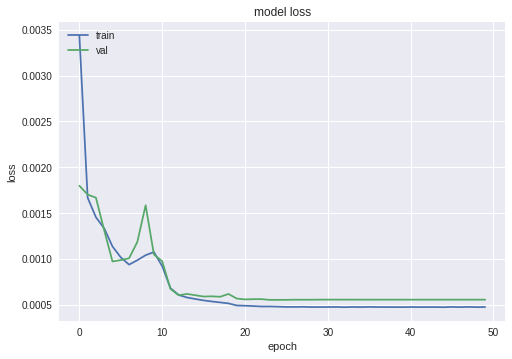

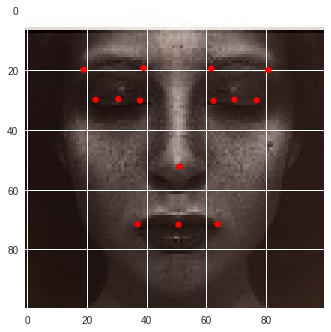

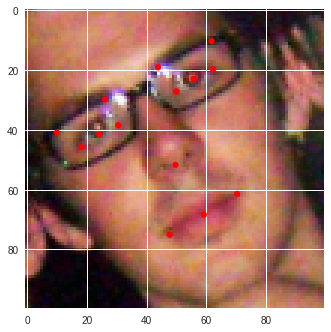

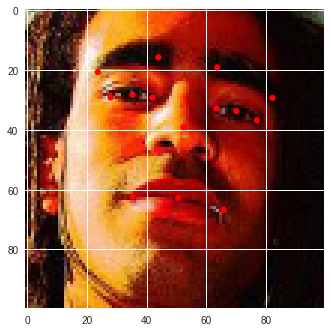

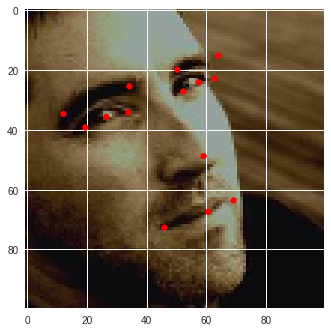

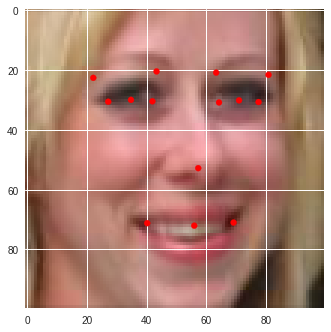

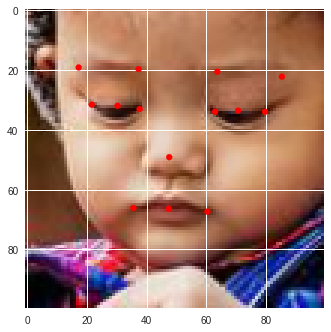

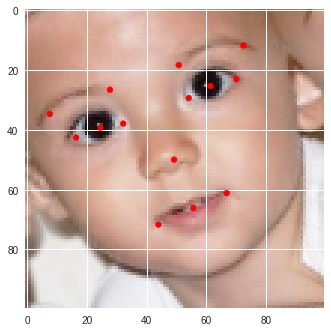

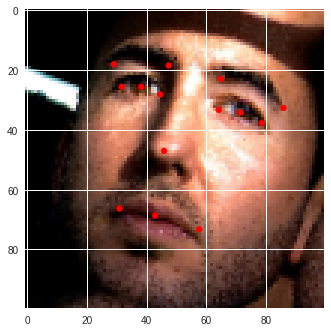

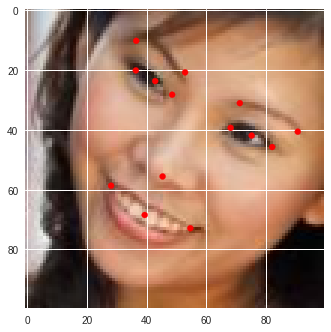

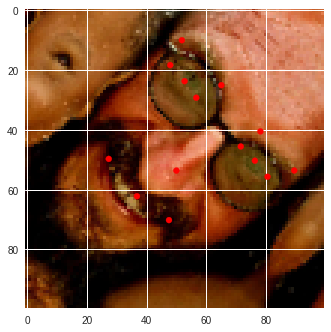

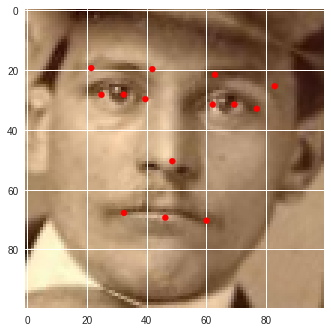

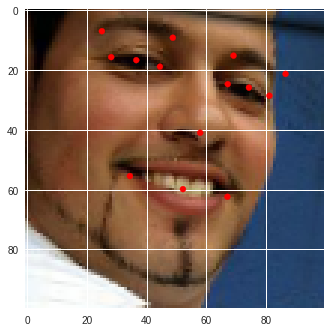

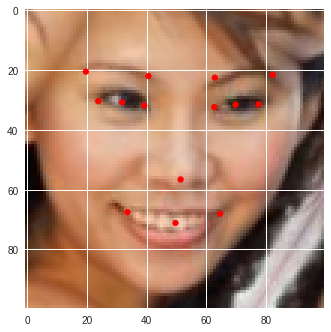

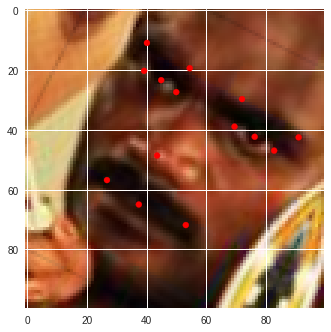

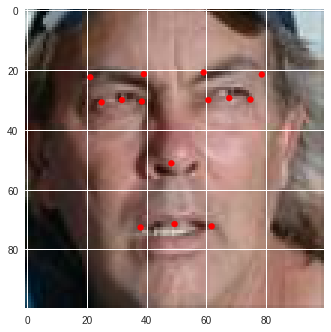

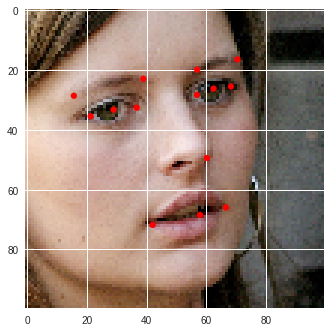

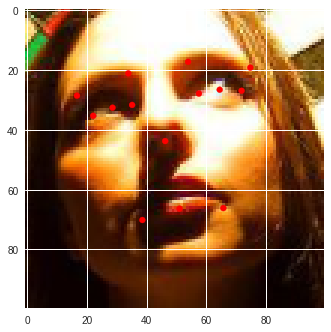

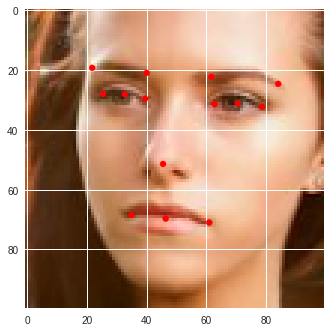

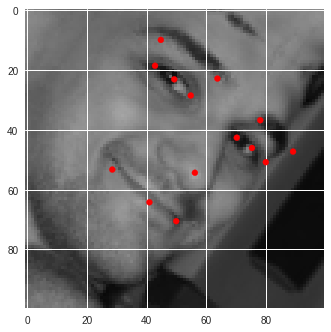

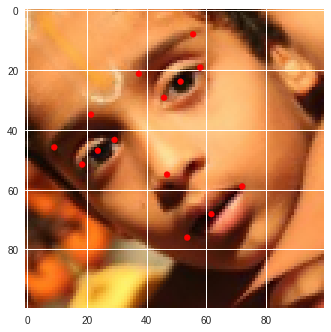

In [1]:
import numpy as np
import os
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.io import imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.model_selection import train_test_split
import math
from skimage import transform

from keras.models import Sequential, Model
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization, Input
)
from keras.regularizers import l2

from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

model = None

#Funkcija koja ucitava podatke, podaci su organizovani tako sto
#imam 6000 slika u folderu images i koordinate kljucnih tacaka lica
#u fajlu gt.csv
def load_images_and_keypoints(dirname='facial-keypoints'):
    imgs_dir = join(dirname, 'images')
    m = 6000
    h = w = 100
    n_landmarks = 14
    imgs = np.zeros((m, h, w, 3))
    points = np.zeros((m, n_landmarks * 2))
    with open(join(dirname, 'gt.csv')) as csv_file:
        header = True
        idx = 0
        for line in csv_file:
            if header:
                header = False
            else:
                #razdvajam liniju po zarezu i citam sliku
                line_split = line.split(',')
                fpath = join(imgs_dir, line_split[0])
                img = imread(fpath)

                #pravim niz brojeva koji predstavljaju koordinate kljucnih tacaka i skaliram ih
                landmarks = np.array([float(x.strip()) for x in line_split[1:]], dtype=np.float32)
                landmarks[: : 2] = landmarks[: : 2] / img.shape[1] - 0.5
                landmarks[1 : : 2] = landmarks[1 : : 2] / img.shape[0] - 0.5

                #resizeovanje slike, stavljanje u imgs i points i uvecanje indexa
                imgs[idx, :, :, :] = resize(img, (h, w, 3))
                points[idx, :] = landmarks
                idx = idx + 1

    return (imgs, points)

#Funkcija koja iscrtava kruzice na kljucnim tackama
#Samo iscrtavanje objekta preko slike je prepisano i prilagodjeno mom slucaju
# https://stackoverflow.com/questions/34902477/drawing-circles-on-image-with-matplotlib-and-numpy
def visualize_points(img, points):
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.imshow(img)
    for idx in range(0, len(points), 2):
        center_x = (points[idx]+0.5)*100
        center_y = (points[idx+1]+0.5)*100
        c = Circle((center_x, center_y), radius=1, color='red')
        ax.add_patch(c)
    plt.show()

#Klasican swap
def swap_points(points, i, j):
    tmp = points[2 * i]
    points[2 * i] = points[2 * j]
    points[2 * j] = tmp
    tmp = points[2 * i + 1]
    points[2 * i + 1] = points[2 * j + 1]
    points[2 * j + 1] = tmp

def flip_img(img, points):
    #raspakivanje tuppl-a i alociranje memorije za nove slike
    rows, cols, channels = img.shape
    fimg = np.zeros(img.shape)

    #flipovanje kolona, fakticki flipujem  u odnosu na x osu
    for col in range(cols):
        fimg[:, cols-col-1, :] = img[:, col, :]

    #kopiram koordinate kljucnih tacaka i inverzujem x koordinatu
    fpoints = np.copy(points)
    fpoints[: : 2] = points[: : 2] * -1

    #Points redom:
    #0->leva tacka leve obrve,
    #1->desna tacka leve obrve,
    #2->leva tacka desne obrve,
    #3->desna tacka desne obrve,
    #4->leva tacka levog oka,
    #5->zenica levog oka,
    #6->desna tacka levog oka,
    #7->leva tacka desnog oka,
    #8->zenica desnog oka,
    #9->desna tacka desnog oka,
    #10->vrh nosa,
    #11->leva tacka na ustima,
    #12->srednja tacka na ustima,
    #13->desna tacka na ustima.
    
    # Swapovanje tacaka tako da je tacka sa indeksom 0
    # leva tacka leve obrve, i tako dalje.
    swap_points(fpoints, 0, 3)
    swap_points(fpoints, 1, 2)
    swap_points(fpoints, 4, 9)
    swap_points(fpoints, 5, 8)
    swap_points(fpoints, 6, 7)
    swap_points(fpoints, 11, 13)
    return fimg, fpoints


def horizontal_flip(img, points):
    #kreiranje nizova za prosirene podatke
    aug_imgs = np.zeros((img.shape[0]*2, img.shape[1], img.shape[2], img.shape[3]))
    aug_points = np.zeros((points.shape[0]*2, points.shape[1]))

    #pakovanje podataka originalnih i novonapravljenih
    for idx in range(img.shape[0]):
        aug_imgs[2*idx], aug_points[2*idx] = img[idx], points[idx]
        aug_imgs[2*idx + 1], aug_points[2*idx + 1] = flip_img(img[idx], points[idx])

    return aug_imgs, aug_points

def random_rotations(imgs, points, theta_deg=45, rot_per_img=1):
    # kreiranje nizova za rotirane slike i njihove tacke
    rot_imgs = np.zeros((imgs.shape[0]*(rot_per_img + 1), imgs.shape[1], imgs.shape[2], imgs.shape[3]))
    rot_points = np.zeros((points.shape[0]*(rot_per_img + 1), points.shape[1]))

    # brojac koliko razlicitih verzija slike imam
    img_versions = rot_per_img + 1

    # Za svaku sliku izvrsavam rotaciju i pakujem zajedno originalne i rotirane slike
    # zajedno sa koordinatama njihovih kljucnih tacaka u rezultujuce nizove
    for idx in range(imgs.shape[0]):
        #Uzimanje indeksa i skladistenje originala u niz koji ce biti rezultujuci
        i = idx * img_versions
        rot_imgs[i] = imgs[idx]
        rot_points[i] = points[idx]

        # Skladistenje zarotiranih slika u isti niz gde su i originali
        for j in range(1, img_versions):
            # Odredjivanje ugla za rotaciju i rotiranje
            deg = np.random.randint(low=-theta_deg, high=theta_deg)
            rad = (deg / 180) * math.pi
            rot_imgs[i + j] = transform.rotate(imgs[idx], deg, mode='reflect')

            # Sredjivanje koordinata kljucnih tacaka za rotiranje slike
            points_2d = np.reshape(points[idx], (14, 2)).T
            rot_matrix = np.array([[np.cos(-rad), -np.sin(-rad)],
                                   [np.sin(-rad), np.cos(-rad)]])
            points_2d_rot = (rot_matrix @ points_2d).T
            rot_points[i + j] = np.reshape(points_2d_rot, (28, ))

    return rot_imgs, rot_points
	
def plot_history(history):
    # Funkcija za iscrtavanje grafika funkcije greske
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def main():
    global model
    #Ucitavanje podataka
    images, points = load_images_and_keypoints(dirname='data')

    #Razdvajanje podataka za trening i za testiranje
    imgs_train, imgs_val, points_train, points_val = train_test_split(images, points, test_size=0.1)

    #Uvecavanje broja podataka oba skupa
    aug_imgs_train, aug_points_train = random_rotations(*horizontal_flip(imgs_train, points_train))
    aug_imgs_val, aug_points_val = random_rotations(*horizontal_flip(imgs_val, points_val))
    
    #Struktura same neuronske mreze
    
    #Ulazni sloj
    #batch_size je 32, slika dimenzije 100x100 piksela, sa 3 kanala za rgb
    input_x = Input(shape=(100,100,3))
    
    #Conv2D sloj sa 8 filtera dimenzije 3x3
    #padding je postavljen na same da bi ostala ista dimenzija slike nakon konvolucije
    #Funkcija aktivacije je elu (exponential linear unit)
    # https://arxiv.org/abs/1511.07289
    x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='elu')(input_x)
    x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='elu')(x)
    
    # MaxPooling2D sloj koji ce smanjiti dimenzije slike
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='elu')(x)
    x = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='elu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='elu')(x)
    x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='elu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='elu')(x)
    x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='elu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='elu')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='elu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='elu')(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='elu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Flatten()(x)
    #Sada kada imam samo 256 bitnih instanci koje sam dobio konvolucijom
    #mogu da koristim potpuno povezane slojeve, takodje sa elu funkcijom aktivacije
    x = Dense(256, activation='elu')(x)
    
    #Dropout sam postavio na 0.25, to mi omogucava da 25% bitnih instanci postavim na 0
    #sto se odrazava na otpornosti mreze na greske
    x = Dropout(0.25)(x)
    x = Dense(128, activation='elu')(x)
    x = Dropout(0.25)(x)
    
    #Poslednji, izlazni sloj, ima 28 bitnih instanci na izlazu, sto predstavlja
    #x i y koordinate mojih kljucnih tacaka na licima ljudi.
    x = Dense(28, activation='linear')(x)

    model = Model(input_x, x)
    model.summary()
	
    #Kompilacija modela, pravljenje grafa
    model.compile(optimizer='adam',
                  loss='mse')
	
    #Pravljenje direktorijuma za checkpointe
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')
        
    #Ove funkcije se pozivaju nakon svake epohe pri treniranju.
    #Prva cuva najbolje modele po funkciji greske na skupu za validaciju
    #Druga vrsi izmene learning-rate-a kada dodje do pogorsanja funkcije greske
    callbacks_list = [
        ModelCheckpoint(filepath='facial_keypoints_{epoch:02d}.hdf5',
                        monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(patience=5, factor=0.1, monitor='loss', verbose=1)]

    
    #Treniranje modela kroz 50 epoha, sa batch-size-om 32
    history = model.fit(aug_imgs_train,
                        aug_points_train,
                        callbacks=callbacks_list,
                        validation_data=(aug_imgs_val, aug_points_val),
                        epochs=50,
                        batch_size = 32)

    #Isrctavanje grafika funkcije greske
    plot_history(history)
	
    #Vrsenje predikcije nad skupom za validaciju
    predictions = model.predict(aug_imgs_val)
	
    for idx in np.random.randint(low=0, high=aug_imgs_val.shape[0], size=(20, )):
        visualize_points(aug_imgs_val[idx], predictions[idx])

if __name__ == '__main__':
    main()



#Ucitavanje najboljeg modela#

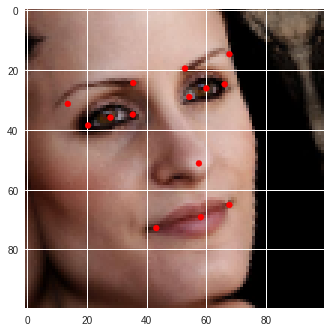

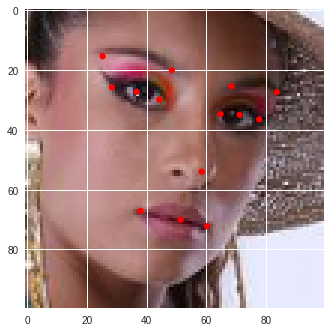

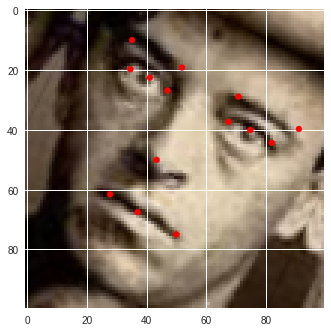

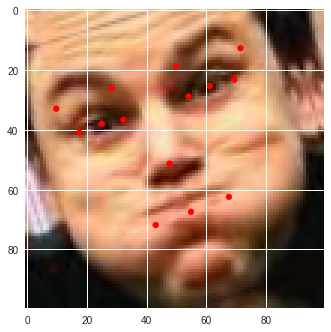

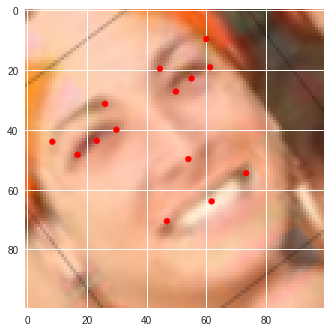

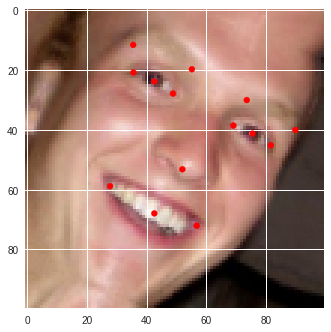

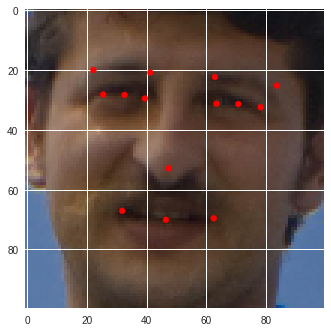

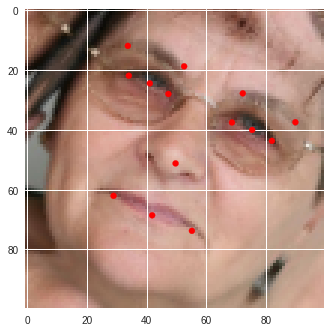

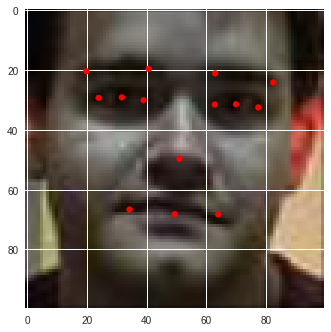

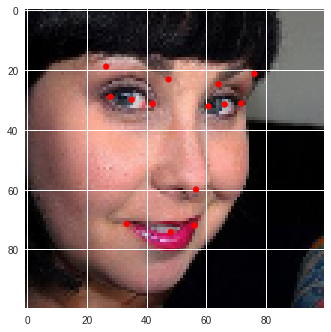

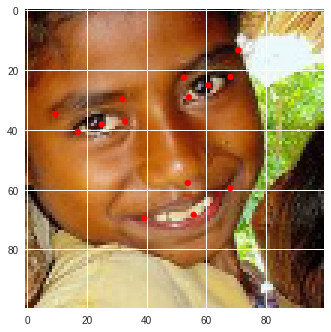

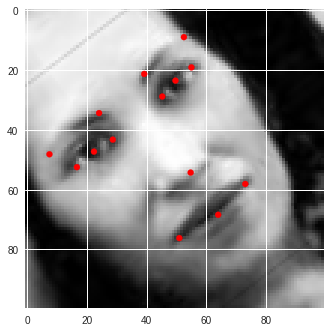

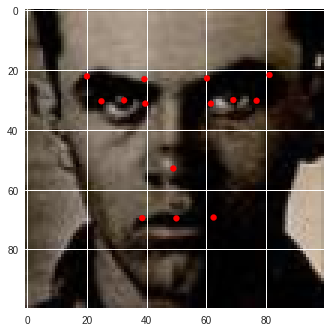

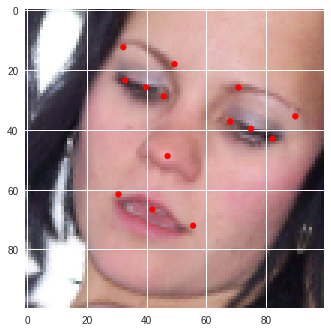

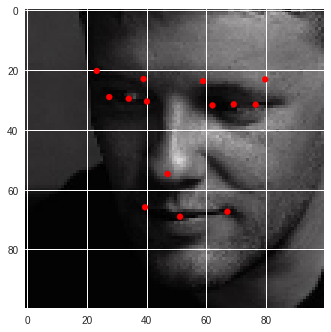

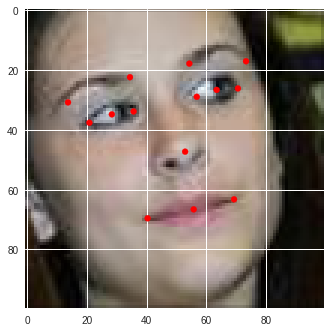

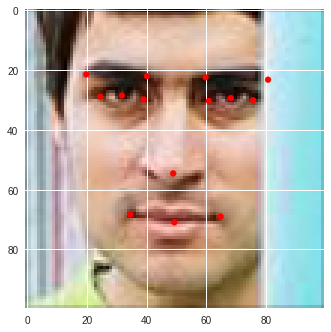

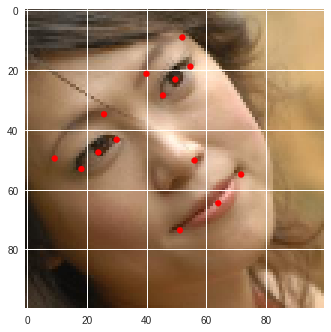

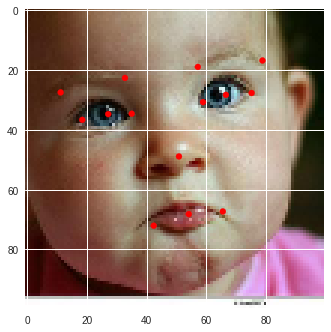

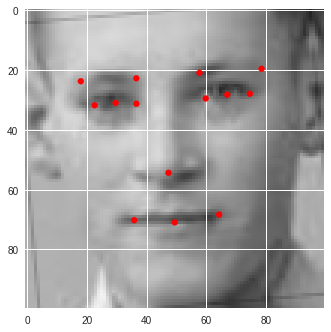

In [3]:
#ucitavanje najboljeg modela i predikcija nad njim
model = load_model('facial_keypoints_24.hdf5')    
    
images, points = load_images_and_keypoints(dirname='data')

#Razdvajanje podataka za trening i za testiranje
imgs_train, imgs_val, points_train, points_val = train_test_split(images, points, test_size=0.1)

#Uvecavanje broja podataka oba skupa
aug_imgs_train, aug_points_train = random_rotations(*horizontal_flip(imgs_train, points_train))
aug_imgs_val, aug_points_val = random_rotations(*horizontal_flip(imgs_val, points_val))

#Vrsenje predikcije nad skupom za validaciju
predictions = model.predict(aug_imgs_val)
	
for idx in np.random.randint(low=0, high=aug_imgs_val.shape[0], size=(20, )):
    visualize_points(aug_imgs_val[idx], predictions[idx])

#Predikcija#

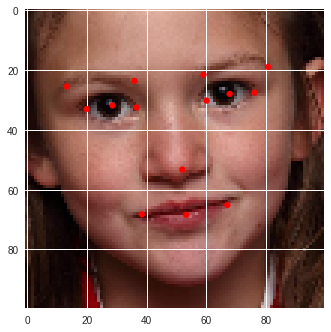

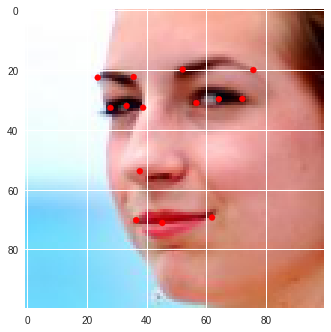

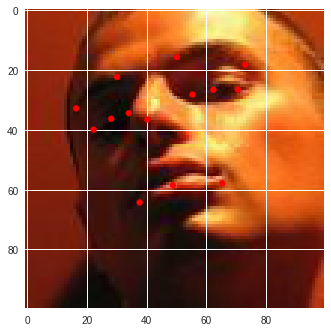

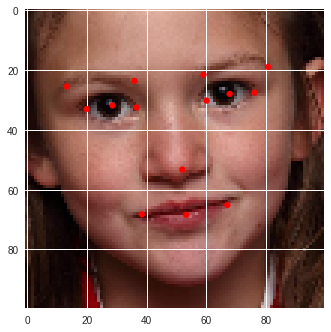

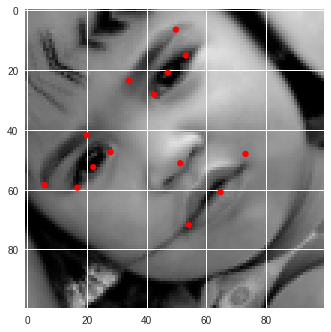

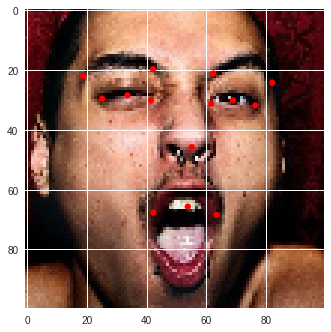

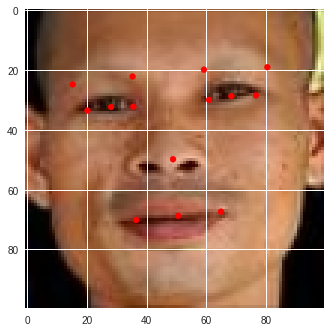

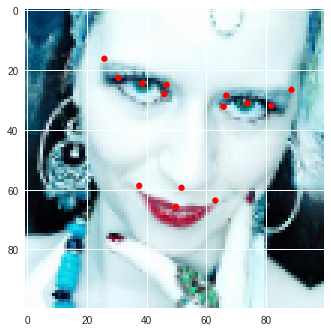

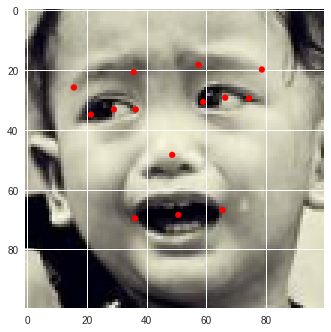

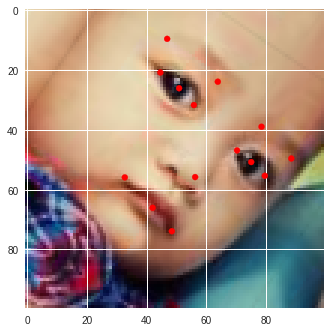

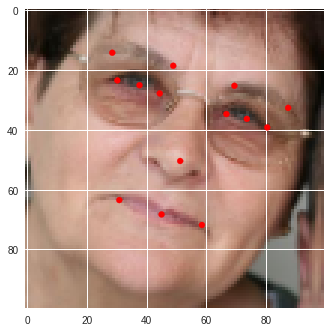

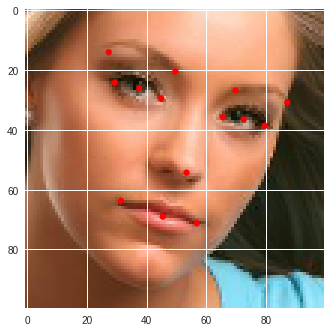

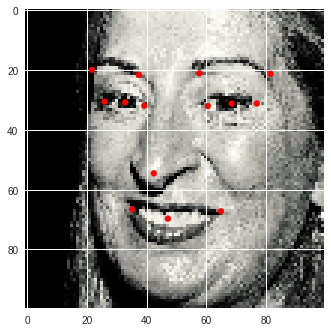

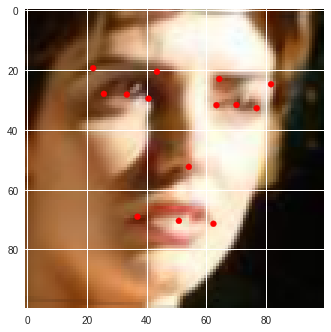

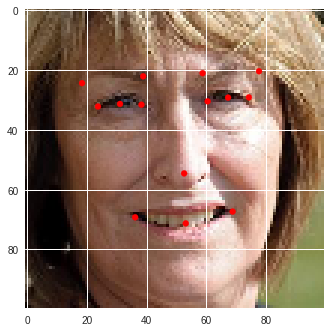

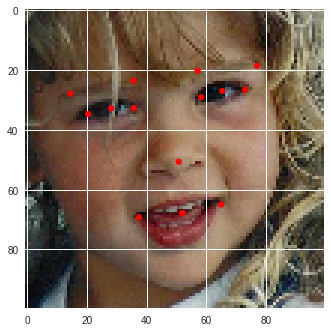

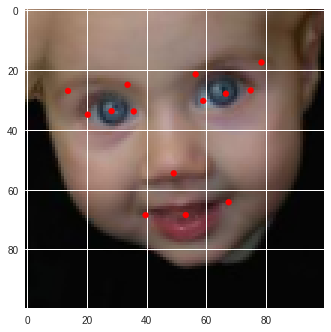

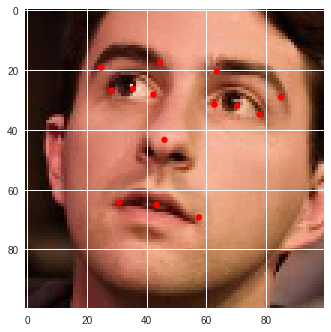

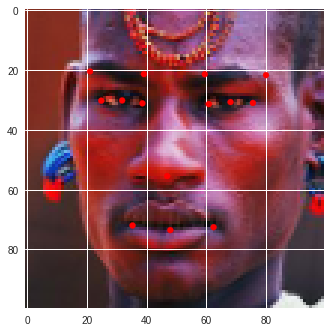

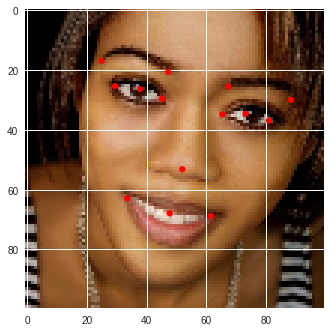

In [5]:
for idx in np.random.randint(low=0, high=aug_imgs_val.shape[0], size=(20, )):
    visualize_points(aug_imgs_val[idx], predictions[idx])